# Análise de Sentimentos dos Comentários da IMDb
por Gleice Garcia
<hr>

### Etapas
<ol type="1">
    <li>Importação dos Dados (50K IMDB Movie Review)</li>
    <li>Limpeza e Pré processamento dos Dados</li>
    <li>Divisão em Treino e Teste</li>
    <li>Tokenize e Pad/Truncate</li>
    <li>Construção do Modelo</li>
    <li>Treino e Teste</li>
</ol>

<hr>

In [1]:
import pandas as pd    
import numpy as np     
from nltk.corpus import stopwords  
from sklearn.model_selection import train_test_split       
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences   
from tensorflow.keras.models import Sequential     
from tensorflow.keras.layers import Embedding, LSTM, Dense 
from tensorflow.keras.callbacks import ModelCheckpoint   
from tensorflow.keras.models import load_model  
import re
import matplotlib.pyplot as plt

In [2]:
df_imdb = pd.read_csv('IMDB Dataset.csv')
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df_imdb.shape

(50000, 2)

In [4]:
df_imdb.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


<AxesSubplot:>

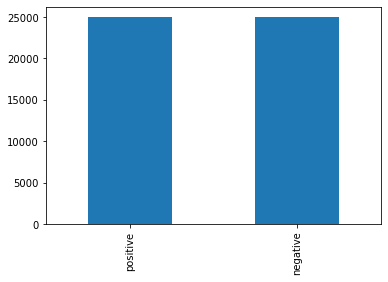

In [5]:
df_imdb['sentiment'].value_counts().plot(kind = 'bar')

<hr>

### Limpeza e Pré processamento dos Dados

Antes da divisão dos dados em treino e teste e da construção do modelo, é fundamental que seja feito um tratamento para remover tags html, pontuações, caracteres não alfanuméricos e palavras 'stopwords'. Além disso, é importante que seja atribuído um valor para os sentimentos positivos e negativos. Neste caso 1 e 0, respectivamente.

In [6]:
# Importa o conjunto de stopwords em inglês 
eng_stops = set(stopwords.words('english'))

In [7]:
df = pd.read_csv('IMDB Dataset.csv')
x_data = df['review']       # Reviews/Input
y_data = df['sentiment']    # Sentiment/Output

# Tratamento do texto
x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove tags html 
x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove caracteres especiais
x_data = x_data.apply(lambda review: [w for w in review.split() if w not in eng_stops])  # remove as stopwords
x_data = x_data.apply(lambda review: [w.lower() for w in review])   # converte para letra minuscula 

In [8]:
# Codificação do sentimento (positivo e negativo)
y_data = y_data.replace('positive', 1)
y_data = y_data.replace('negative', 0)

<hr>

### Divisão em Treino e Teste
Os dados são divididos 80% em treino e 20% em teste através da função train_test_split(). Essa função embaralha os dados no momento em que separa os dados em dois conjuntos e isso é importante porque no conjunto de dados origina as avaliações e os sentimentos estão em ordem, primeiro avaliações positivas e depois as negativas. Isso garante que os dados serão distribuídos igualmente no modelo, trazendo maior precisão para as previsões.

In [9]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x_data, y_data, test_size = 0.2)

print('Conjunto de Treino')
print(x_treino, '\n')
print('Conjunto de Teste')
print(x_teste, '\n')
print('Conjunto de Treino')
print(y_treino, '\n')
print('Conjunto de Teste')
print(y_teste)

Conjunto de Treino
33815    [the, five, deadly, venoms, great, kung, fu, a...
42244    [a, realistic, depiction, young, love, college...
33310    [this, movie, tries, first, acting, horrible, ...
11160    [i, say, one, thing, herman, usa, probably, al...
43819    [a, plane, carrying, rich, scientist, daughter...
                               ...                        
35233    [i, believe, amount, reviewers, praise, realis...
7934     [enjoyed, movie, efficient, confucian, crime, ...
30268    [where, sidewalk, ends, quite, good, film, noi...
34064    [naturally, sadie, sucks, big, time, i, idea, ...
44934    [errol, flynn, greatest, movie, sports, movie,...
Name: review, Length: 40000, dtype: object 

Conjunto de Teste
46679    [in, early, th, century, young, woman, harelip...
19085    [i, marine, camp, pendleton, d, i, came, st, m...
16626    [what, i, say, this, movie, romance, break, up...
34758    [i, big, fan, faerie, tale, theatre, i, seen, ...
7609     [screen, treatment, come

<hr>

### Tokenize, Pad/Truncate 
Após a divisão dos dados em conjuntos de treinamento e teste, é necessário transformar os comentários em dados númericos inteiros. 
Além disso, pelos comentários terem comprimentos diferentes foi preciso fazer um preenchimento com zeros, para que ficassem todas com o mesmo tamanho.

In [10]:
# função para encontrar o comprimento máximo das resenhas pela média de comprimento geral.
def maior_tamanho():
    comprimento = []
    for review in x_treino:
        comprimento.append(len(review))

    return int(np.ceil(np.mean(comprimento)))

In [11]:
token = Tokenizer(lower=False)   
token.fit_on_texts(x_treino)
x_treino = token.texts_to_sequences(x_treino)
x_teste = token.texts_to_sequences(x_teste)

In [12]:
max_len = maior_tamanho()

x_treino = pad_sequences(x_treino, maxlen=max_len, padding='post', truncating='post')
x_teste = pad_sequences(x_teste, maxlen=max_len, padding='post', truncating='post')

total_palavras = len(token.word_index) + 1

print('Encoded X Train\n', x_treino, '\n')
print('Encoded X Test\n', x_teste, '\n')
print('Maximum review length: ', max_len)

Encoded X Train
 [[    2   604  2407 ...     0     0     0]
 [   39   695  2504 ...     0     0     0]
 [    8     3   417 ...     0     0     0]
 ...
 [ 1077  7546   553 ...     0     0     0]
 [ 1848 12740  1548 ...     0     0     0]
 [ 5633  3210   730 ...     0     0     0]] 

Encoded X Test
 [[   49   315   692 ...    11   134  3426]
 [    1  5014  1106 ...  6508  1738 34418]
 [  105     1    58 ...     0     0     0]
 ...
 [    1   114  9213 ...     0     0     0]
 [ 2013   238  5300 ...     0     0     0]
 [   39  5026  4855 ...     0     0     0]] 

Maximum review length:  130


<hr>

### Construção do Modelo

**Camada embedding**: Utilizada para vetorizar o texto. O embedding de palavras faz a representação na qual, por meio de um agrupamento, palavras semelhantes têm codificação semelhante. Os valores para o embedding são parâmetros treináveis (pesos aprendidos durante o treinamento, da mesma maneira que um modelo aprende pesos para uma camada densa). 

**Camada LSTM** : tem a capacidade tanto de lembrar quanto de esquecer
o estado anterior quando essa informação não for mais necessária. Seus componentes são: 

**Forget Gate** : decide qual informação manter ou esquecer;

**Input Gate** : adição de informações úteis ao estado da célula (blocos de memória) passando a saída anterior e a entrada atual na função de ativação sigmóide. Os valores do vetor e os valores regulados são multiplicados para obter as informações úteis.

**Output Gate** : extrair informações úteis do estado da célula atual para ser apresentadas como uma saída

**Camada Densa** : calcula a entrada com a matriz de peso e bias (opcional), e usando uma função de ativação.

Foi utilizado o otimizador Adam e a função de custo Binary Crossentropy já que a saída é binária.


In [13]:
emb_dim = 32 # o comprimento do vetor é um parâmetro. Números menores são ideais para conjuntos menores.
lstm_out = 64

model = Sequential()
model.add(Embedding(total_palavras, emb_dim, input_length = max_len))
model.add(LSTM(lstm_out))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 32)           2964832   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,989,729
Trainable params: 2,989,729
Non-trainable params: 0
_________________________________________________________________
None


<hr>

### Treino

O treino consiste em ajustar os dados de entrada (x_treino) e de saída/rótulo (y_treino). Para isso foi utilizado o método de aprendizado de mini-batch com batch_size de 128 e 5 épocas.

Foi adicionado um checkpoint para salvar o modelo localmente para cada época se sua precisão melhorar em relação a anterior.

In [14]:
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [15]:
model.fit(x_treino, y_treino, batch_size = 128, epochs = 5, callbacks=[checkpoint])

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.7300
Epoch 00001: accuracy improved from -inf to 0.72995, saving model to models\LSTM.h5
313/313 [==============================] - 59s 172ms/step - loss: 0.4960 - accuracy: 0.7300
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9183
Epoch 00002: accuracy improved from 0.72995 to 0.91833, saving model to models\LSTM.h5
313/313 [==============================] - 45s 145ms/step - loss: 0.2259 - accuracy: 0.9183
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9606
Epoch 00003: accuracy improved from 0.91833 to 0.96055, saving model to models\LSTM.h5
313/313 [==============================] - 48s 154ms/step - loss: 0.1283 - accuracy: 0.9606
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 0.9723
Epoch 00004: accuracy improved from 0.96055 to 0.97228, saving model to models\LSTM.h5

<hr>


### Teste

O teste consiste em avaliar se o modelo consegue prever o sentimento dos comentários novos (x_teste) comparando com os rótulos destes comentários (y_teste). Em seguida é calculada a precisão do modelo que resultou em 87,25%.


In [16]:
y_pred = (model.predict(x_teste) > 0.5).astype("int32")

true = 0
for i, y in enumerate(y_teste):
    if y == y_pred[i]:
        true += 1

print('Predições corretas: {}'.format(true))
print('Predições incorretas: {}'.format(len(y_pred) - true))
print('Acurácia: {}'.format(true/len(y_pred)*100))

Predições corretas: 8689
Predições incorretas: 1311
Acurácia: 86.89


<hr>

### Resultados 

In [17]:
loaded_model = load_model('models/LSTM.h5') # modelo salvo

In [109]:
# o modelo recebe um commentário para ser classificado
comentario_1 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_2 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_3 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_4 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_5 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_6 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_7 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_8 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_9 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_10 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_11 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_12 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_13 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_14 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_15 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_16 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_17 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_18 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_19 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_20 = str(input('Comentário sobre o filme: '))

Comentário sobre o filme: I have never been so bored watching a film. Every shot seems to be way longer than it should be making it a very slow and boring film. Not to mention Robert Pattinsons boring monotone mumble throughout the film. There were several points where I was relieved because I thought the film was about to come to an end.


Comentário sobre o filme: It felt really flat and boring. God, I hope they don't make a third one. Or at least they can pick a Poirot case that hasn't been made into a film before, but a hundred times better


Comentário sobre o filme: I feel like i wasted my time.didn't get the feeling of adventure . Although it was funny most of the point . But the story was not great . I have heard time to figure out what's going there.


Comentário sobre o filme: I was bored during 95% of the movie. It had 10 minutes of action and rest of movie is just a bad story. I don't recomend this movie except if you want to fall a sleep then this is movie for you.


Comen

In [110]:
# a entrada é pré processada antes de passar pelo modelo
regex = re.compile(r'[^a-zA-Z\s]')
comentario_1 = regex.sub('', comentario_1)
comentario_2 = regex.sub('', comentario_2)
comentario_3 = regex.sub('', comentario_3)
comentario_4 = regex.sub('', comentario_4)
comentario_5 = regex.sub('', comentario_5)
comentario_6 = regex.sub('', comentario_6)
comentario_7 = regex.sub('', comentario_7)
comentario_8 = regex.sub('', comentario_8)
comentario_9 = regex.sub('', comentario_9)
comentario_10 = regex.sub('', comentario_10)
comentario_11 = regex.sub('', comentario_11)
comentario_12 = regex.sub('', comentario_12)
comentario_13 = regex.sub('', comentario_13)
comentario_14 = regex.sub('', comentario_14)
comentario_15 = regex.sub('', comentario_15)
comentario_16 = regex.sub('', comentario_16)
comentario_17 = regex.sub('', comentario_17)
comentario_18 = regex.sub('', comentario_18)
comentario_19 = regex.sub('', comentario_19)
comentario_20 = regex.sub('', comentario_20)
#print('Comentário 1 tratado (negativo): ', comentario_1)
#print('\n')
#print('Comentário 2 tratado (negativo): ', comentario_2)
#print('\n')
#print('Comentário 3 tratado (positivo): ', comentario_3)
#print('\n')
#print('Comentário 4 tratado (positivo): ', comentario_4)

In [111]:
palavras = comentario_1.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_1 = [filtro.lower()]


In [112]:
palavras = comentario_2.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_2 = [filtro.lower()]


In [113]:
palavras = comentario_3.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_3 = [filtro.lower()]


In [114]:
palavras = comentario_4.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_4 = [filtro.lower()]


In [115]:
palavras = comentario_5.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_5 = [filtro.lower()]


In [116]:
palavras = comentario_6.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_6 = [filtro.lower()]


In [117]:
palavras = comentario_7.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_7 = [filtro.lower()]


In [118]:
palavras = comentario_8.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_8 = [filtro.lower()]


In [119]:
palavras = comentario_9.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_9 = [filtro.lower()]


In [120]:
palavras = comentario_10.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_10 = [filtro.lower()]


In [121]:
palavras = comentario_11.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_11 = [filtro.lower()]


In [122]:
palavras = comentario_12.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_12 = [filtro.lower()]


In [123]:
palavras = comentario_13.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_13 = [filtro.lower()]


In [124]:
palavras = comentario_14.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_14 = [filtro.lower()]


In [125]:
palavras = comentario_15.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_15 = [filtro.lower()]


In [126]:
palavras = comentario_16.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_16 = [filtro.lower()]


In [127]:
palavras = comentario_17.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_17 = [filtro.lower()]


In [128]:
palavras = comentario_18.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_18 = [filtro.lower()]


In [129]:
palavras = comentario_19.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_19 = [filtro.lower()]


In [130]:
palavras = comentario_20.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_20 = [filtro.lower()]


In [131]:
# as palavras são codificadas 
palavras_codificadas_1 = token.texts_to_sequences(filtro_1)
palavras_codificadas_1 = pad_sequences(palavras_codificadas_1, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_1)

[[    1    40  1009    66     4    84   226    94    26  1053   139   470
    260     4   159   650   516   260  8925 19104   370     4    50   350
    705     1  9122     1    98     4   123    55     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [132]:
# as palavras são codificadas 
palavras_codificadas_2 = token.texts_to_sequences(filtro_2)
palavras_codificadas_2 = pad_sequences(palavras_codificadas_2, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_2)

[[    7   338    14   954   260   413     1   339  5216    25   783     5
    840   129  1081  6809   322 83058    24     4  3084   120    53     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [133]:
# as palavras são codificadas 
palavras_codificadas_3 = token.texts_to_sequences(filtro_3)
palavras_codificadas_3 = pad_sequences(palavras_codificadas_3, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_3)

[[   1  137    6  914   19  463 1069  167   70  126   30   13   20    1
   459   10  740 4479   80    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [134]:
# as palavras são codificadas 
palavras_codificadas_4 = token.texts_to_sequences(filtro_4)
palavras_codificadas_4 = pad_sequences(palavras_codificadas_4, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_4)

[[    1  1009     3     7   135   115   280     3    18    13     1  5216
  19045     3   449    89   678  1594     3     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [135]:
palavras_codificadas_5 = token.texts_to_sequences(filtro_5)
palavras_codificadas_5 = pad_sequences(palavras_codificadas_5, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_5)

[[ 727    9  383   20   12   45   33 1092  936 8464  112  784  614 1325
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [136]:
palavras_codificadas_6 = token.texts_to_sequences(filtro_6)
palavras_codificadas_6 = pad_sequences(palavras_codificadas_6, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_6)

[[    1   570   704     1   114    84     9   742     2     3     9   466
      2    41     4    73    91  6784    22  1728  4094    29    16  1302
     11    13   415    29   641     2  2467     4   734   294   727    14
    515 14335     4  1085  2813    14    18    41     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [137]:
palavras_codificadas_7 = token.texts_to_sequences(filtro_7)
palavras_codificadas_7 = pad_sequences(palavras_codificadas_7, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_7)

[[  43  395    9  369  787 1825  159  157   21  630  209  566 5216  353
   194  260   13  759 6385 1118    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [138]:
palavras_codificadas_8 = token.texts_to_sequences(filtro_8)
palavras_codificadas_8 = pad_sequences(palavras_codificadas_8, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_8)

[[ 727 2526   30   26 1389  100  260  569    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [139]:
palavras_codificadas_9 = token.texts_to_sequences(filtro_9)
palavras_codificadas_9 = pad_sequences(palavras_codificadas_9, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_9)

[[  105   353    10   669 44248   127    33  1553    65   102   456   100
   1353     7   135   206  4911     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [140]:
palavras_codificadas_10 = token.texts_to_sequences(filtro_10)
palavras_codificadas_10 = pad_sequences(palavras_codificadas_10, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_10)

[[  279  1433   304  4573   534   260     1   365    22   592  2241   821
   1199     1   968   279  1683   260    13   890 13022   852     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [141]:
palavras_codificadas_11 = token.texts_to_sequences(filtro_11)
palavras_codificadas_11 = pad_sequences(palavras_codificadas_11, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_11)

[[ 2107   267  1429 91915 16470   362  2583  4460 21833 11925   735  1943
  10366    54  1687    88   191    23   112  5109     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [142]:
palavras_codificadas_12 = token.texts_to_sequences(filtro_12)
palavras_codificadas_12 = pad_sequences(palavras_codificadas_12, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_12)

[[   44   260    27    33  2305    55  8651   555   728 12115     9  1011
   1566  4528  1476   756     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [143]:
palavras_codificadas_13 = token.texts_to_sequences(filtro_13)
palavras_codificadas_13 = pad_sequences(palavras_codificadas_13, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_13)

[[  260   762  1028  6281  9743   728 12115  4171   122   354    43    18
      2   383   106  5538  1474   982     1   110   263   566   353    10
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [144]:
palavras_codificadas_14 = token.texts_to_sequences(filtro_14)
palavras_codificadas_14 = pad_sequences(palavras_codificadas_14, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_14)

[[   1 1358    1  838 2752 7583 8071    7  914    2  708 9475 4272  653
     1  914   10    3   53   28    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [145]:
palavras_codificadas_15 = token.texts_to_sequences(filtro_15)
palavras_codificadas_15 = pad_sequences(palavras_codificadas_15, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_15)

[[   16  2510   391    43     2  1370   852   453   554   853    26  1548
    961     1    14  2173  2013  2173    61  5538 14751   486    17     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [146]:
palavras_codificadas_16 = token.texts_to_sequences(filtro_16)
palavras_codificadas_16 = pad_sequences(palavras_codificadas_16, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_16)

[[ 3842  1912    39  8796   739     1   386    25    55    36 27186     1
     14   360   110   509  5216   353    10     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [147]:
palavras_codificadas_17 = token.texts_to_sequences(filtro_17)
palavras_codificadas_17 = pad_sequences(palavras_codificadas_17, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_17)

[[    1    47    28   895   194   123 13288   101    22  1376   119    33
  14183  1566  4528   461   507  1034   194  1512    87     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [148]:
palavras_codificadas_18 = token.texts_to_sequences(filtro_18)
palavras_codificadas_18 = pad_sequences(palavras_codificadas_18, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_18)

[[   1   14  102 1009   66 1727    1   19 2173   66 4689   28   30    1
    14 1009    3 4272 1140  129 2746 2321    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [149]:
palavras_codificadas_19 = token.texts_to_sequences(filtro_19)
palavras_codificadas_19 = pad_sequences(palavras_codificadas_19, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_19)

[[    1   291  1166     4   414    24   787   260     3   100   697  3073
     33   370   130     3     1    31    12    25    53   173     4     1
     12   282   245   173   245    13    11    66     4  5375   126 13471
    641     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [150]:
palavras_codificadas_20 = token.texts_to_sequences(filtro_20)
palavras_codificadas_20 = pad_sequences(palavras_codificadas_20, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_4)

[[    1  1009     3     7   135   115   280     3    18    13     1  5216
  19045     3   449    89   678  1594     3     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [151]:
# pontuação de confiança do previsão da classe do comentário
resultado_1 = loaded_model.predict(palavras_codificadas_1)
print(resultado_1)

[[0.00535288]]


In [152]:
resultado_2 = loaded_model.predict(palavras_codificadas_2)
print(resultado_2)

[[0.00888306]]


In [153]:
resultado_3 = loaded_model.predict(palavras_codificadas_3)
print(resultado_3)

[[0.4441603]]


In [154]:
resultado_4 = loaded_model.predict(palavras_codificadas_4)
print(resultado_4)

[[0.00578529]]


In [155]:
resultado_5 = loaded_model.predict(palavras_codificadas_5)
print(resultado_5)

[[0.9515253]]


In [156]:
resultado_6 = loaded_model.predict(palavras_codificadas_6)
print(resultado_6)

[[0.00801575]]


In [157]:
resultado_7 = loaded_model.predict(palavras_codificadas_7)
print(resultado_7)

[[0.00528976]]


In [158]:
resultado_4 = loaded_model.predict(palavras_codificadas_4)
print(resultado_4)

[[0.00578529]]


In [159]:
resultado_5 = loaded_model.predict(palavras_codificadas_5)
print(resultado_5)

[[0.9515253]]


In [160]:
resultado_6 = loaded_model.predict(palavras_codificadas_6)
print(resultado_6)

[[0.00801575]]


In [161]:
resultado_7 = loaded_model.predict(palavras_codificadas_7)
print(resultado_7)

[[0.00528976]]


In [162]:
resultado_8 = loaded_model.predict(palavras_codificadas_8)
print(resultado_8)

[[0.00679103]]


In [163]:
resultado_9 = loaded_model.predict(palavras_codificadas_9)
print(resultado_9)

[[0.00647989]]


In [164]:
resultado_10 = loaded_model.predict(palavras_codificadas_10)
print(resultado_10)

[[0.00521457]]


In [165]:
resultado_11 = loaded_model.predict(palavras_codificadas_11)
print(resultado_11)

[[0.00812563]]


In [166]:
resultado_12 = loaded_model.predict(palavras_codificadas_12)
print(resultado_12)

[[0.0517298]]


In [167]:
resultado_13 = loaded_model.predict(palavras_codificadas_13)
print(resultado_13)

[[0.00705668]]


In [168]:
resultado_14 = loaded_model.predict(palavras_codificadas_14)
print(resultado_14)

[[0.0112986]]


In [169]:
resultado_15 = loaded_model.predict(palavras_codificadas_15)
print(resultado_15)

[[0.00599733]]


In [170]:
resultado_16 = loaded_model.predict(palavras_codificadas_16)
print(resultado_16)

[[0.00607622]]


In [171]:
resultado_17 = loaded_model.predict(palavras_codificadas_17)
print(resultado_17)

[[0.09006563]]


In [172]:
resultado_18 = loaded_model.predict(palavras_codificadas_18)
print(resultado_18)

[[0.0326027]]


In [173]:
resultado_19 = loaded_model.predict(palavras_codificadas_19)
print(resultado_19)

[[0.00611016]]


In [174]:
resultado_20 = loaded_model.predict(palavras_codificadas_20)
print(resultado_20)

[[0.08239356]]


In [175]:
# se a pontuação estiver mais próxima de 0, o comentário tem sentimento negativo. Em contrapartida, se a pontuação estiver próxima a 1, o comentário é positivo.
# foi utilizado um threshold de 0,7 para determinar se a pontuação representa um comentário positivo  ou negativo. Portanto, pontuação maior de 0,7 é positiva e menor que 0,7 é negativa.

if resultado_1 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [176]:
if resultado_2 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [177]:
if resultado_3 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [178]:
if resultado_4 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [179]:
if resultado_5 >= 0.7:
    print('positivo')
else:
    print('negativo')

positivo


In [180]:
if resultado_6 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [181]:
if resultado_7 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [182]:
if resultado_8 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [183]:
if resultado_9 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [184]:
if resultado_10 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [185]:
if resultado_11 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [186]:
if resultado_12 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [187]:
if resultado_13 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [188]:
if resultado_14 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [189]:
if resultado_15 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [190]:
if resultado_16 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [191]:
if resultado_17 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [192]:
if resultado_18 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [193]:
if resultado_19 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [194]:
if resultado_20 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo
